In [ ]:
# !pip install optuna

In [21]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import optuna
from sklearn.metrics import confusion_matrix

import plotly
#import plotly.express as px
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
#plt.style.use('seaborn')

import warnings # для игнорирования предупреждений
# Игнорируем предупреждения
warnings.filterwarnings('ignore')


In [22]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


### Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [23]:
pridict_column = 'Activity'
X = data.drop( [pridict_column], axis = 1 )
y = data[pridict_column]

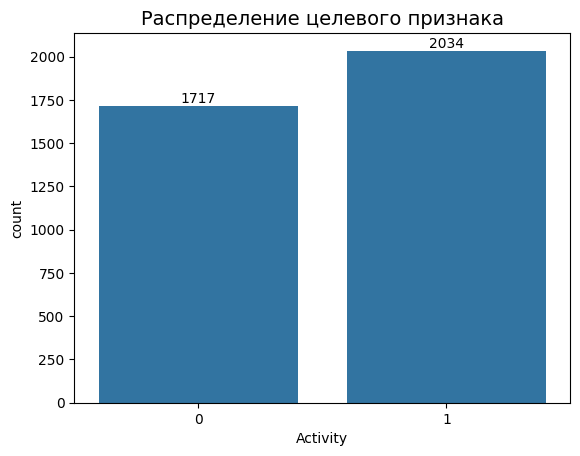

In [4]:
ax = sns.countplot(x='Activity',data=y.to_frame())
for container in ax.containers:
    ax.bar_label(container)

ax.set_title( 'Распределение целевого признака', size = 14 )

plt.show()

### Целевой признак булев ==> Имеем задачу бинарной классификации

### Разделяем выборку на стратифицированную тренировочную и тестовую в соотношении 75/25.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.25)
print( f"X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}" )

X_train: (2813, 1776)
X_test: (938, 1776)
y_train: (2813,)
y_test: (938,)


In [102]:
random_state = 42 # Для повторяемости результата
cv = 5 # Кодичество фолдов для тестов
best_params = {} # Словарь найденных гиперпараметров 
max_iter = 1000 # Количество итераций для линейной регрессии
n_iter = 10 # Количество попыток для RandomizedSearchCV

Библиотечные функции

In [167]:
############################################################################################
# Генерирует список из cnt_items чисел из числа var. По умолчанию 7 чисел в диапазоне от [0.7 * var, 1.3 * var ]
#
# Вход:
#    var - Порождающее число 
#    cnt_items - размер генерируемого списка, нечетное число
#
# Выход:
#    Список cnt_items чисел с центром в cnt_items
#
# Пример:
#    recalc_param_C( 100, 7 ) ==> [70, 80, 90, 100, 110, 120, 130]
#    recalc_param_C( 0.1, 7 ) ==> [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]
#
############################################################################################
def recalc_param_C( var, cnt_items = 7 ):
    deviation = 1 - (cnt_items - 1) / 20
    arr_var = [var]
    if var < 1:
        arr_var = [round((deviation + x * 0.1) * var, 6) for x in range( cnt_items ) ]
    elif var % 10 == 0:
        arr_var = [int(round((deviation + x * 0.1) * var, 0)) for x in range( cnt_items ) ]
    else:
        arr_var = [(deviation + x * 0.1) * var for x in range( cnt_items ) ]
    print( f'Уточняем: C = {arr_var}' )
    return arr_var

############################################################################################
# Обучает модель model, возвращает предсказанные серии и печатает метрики
#
# Вход:
#    model - Экземпляр объекта модели предсказания
#    X_train, y_train - Обучающие массивы наблюденний и результатов
#    X_test, y_test - Тестовые массивы наблюденний и результатов
#
# Выход:
#    Кортеж предсказанных значений для тестовой и обучающей выборки
#
############################################################################################
def run_model_fit( model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = True ):
    # Обучаем модель
    model.fit(X_train, y_train)
    return run_model_predict( model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = f_plot )
    

############################################################################################
# Обучает модель model, возвращает предсказанные серии и печатает метрики
#
# Вход:
#    model - Экземпляр объекта модели предсказания
#    X_train, y_train - Обучающие массивы наблюденний и результатов
#    X_test, y_test - Тестовые массивы наблюденний и результатов
#
# Выход:
#    Кортеж предсказанных значений для тестовой и обучающей выборки
#
############################################################################################
def run_model_predict( model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = True ):
    y_train_pred = model.predict( X_train )
    y_test_pred = model.predict( X_test )

    f1_score_train_pred = metrics.f1_score(y_train, y_train_pred)
    f1_score_test_pred = metrics.f1_score(y_test, y_test_pred)
    
    print( f'f1_score на обучающем наборе: {f1_score_train_pred:.2f}' )
    print( f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}' )

    if f_plot:
        plot_confusion_matrix( y_test, y_test_pred, 'Матрица конфузий' )
    
    return (f1_score_train_pred, f1_score_test_pred, y_train_pred, y_test_pred)


############################################################################################
#
# Запускает настроенный экземпляр класса GridSearchCV или RandomizedSearchCV на поиск лучшего набора гиперпараметров
# Найдя лучший набор, обучает модель и возвращяет предсказанные значения, печатает метрики
#
# Вход:
#    obj_SearchCV - Экземпляр объекта GridSearchCV или RandomizedSearchCV
#    X_train, y_train - Обучающие массивы наблюденний и результатов
#    X_test, y_test - Тестовые массивы наблюденний и результатов
#
# Выход:
#    Кортеж bp GridSearchCV или RandomizedSearchCV и предсказанных значений для тестовой выборки
#
############################################################################################
def run_SearchCV_fit( obj_SearchCV, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = False ):
    %time obj_SearchCV.fit( X_train, y_train )

    print( f"Наилучшие значения гиперпараметров: {obj_SearchCV.best_params_}" )
    _, _, _, y_test_pred = run_model_fit( obj_SearchCV.best_estimator_, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = f_plot )
    
    return (obj_SearchCV, y_test_pred)


############################################################################################
#
# Запускает настроенный экземпляр класса GridSearchCV на поиск лучшего набора гиперпараметров
# Найдя лучший набор, обучает модель и возвращяет предсказанные значения, печатает метрики
#
# Вход:
#    obj_SearchCV - Экземпляр объекта GridSearchCV 
#    X_train, y_train - Обучающие массивы наблюденний и результатов
#    X_test, y_test - Тестовые массивы наблюденний и результатов
#
# Выход:
#    Кортеж из GridSearchCV или RandomizedSearchCV и предсказанных значений для тестовой выборки
#
############################################################################################
def run_GridSearchCV( params, model, cv = cv, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = False ):
    obj_seach = GridSearchCV(
        estimator = model, # Модель обучения
        param_grid = params, # Словарь с пространством поиска гиперпараметров
        cv = cv, # Количество фолдов
        n_jobs = -1, # Все доступные ядра
        scoring = 'f1', # F1-Score
    )  
    return run_SearchCV_fit( obj_seach, X_train, y_train, X_test, y_test, f_plot )


############################################################################################
#
# Запускает настроенный экземпляр класса RandomizedSearchCV на поиск лучшего набора гиперпараметров
# Найдя лучший набор, обучает модель и возвращяет предсказанные значения, печатает метрики
#
# Вход:
#    obj_SearchCV - Экземпляр объекта RandomizedSearchCV
#    X_train, y_train - Обучающие массивы наблюденний и результатов
#    X_test, y_test - Тестовые массивы наблюденний и результатов
#
# Выход:
#    Кортеж из GridSearchCV или RandomizedSearchCV и предсказанных значений для тестовой выборки
#
############################################################################################
def run_RandomizedSearchCV( params, model, cv = cv, n_iter = 20, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = False ):
    obj_seach = RandomizedSearchCV(
        estimator = model, # Модель обучения
        param_distributions = params, # Словарь с пространством поиска гиперпараметров
        cv = cv, # Количество фолдов
        n_iter = n_iter, # Количество итераций случайного выбора
        n_jobs = -1, # Все доступные ядра
        scoring = 'f1', # F1-Score
    ) 
    return run_SearchCV_fit( obj_seach, X_train, y_train, X_test, y_test, f_plot )   


############################################################################################
#
# Печатает матрицу конфузий по паре массивов y, y_pred
#
############################################################################################
def plot_confusion_matrix( y, y_pred, header = '', ax = None ):
    sns.set( rc = {'figure.figsize':(4, 4)} ) #задаем размер графика
    ax = sns.heatmap(confusion_matrix( y, y_pred ), center = True, annot = True, fmt='', ax=ax)
    ax.set_title( header )  # Подписи по оси y
     # Добавляем название графику и подписи осей абсцисс и ординат
    ax.set_xlabel('y предсказанное') 
    ax.set_ylabel('y истинное')


############################################################################################
#
############################################################################################
def plot_metrics( cv_results, y, y_pred_init, title = '' ):  
    fig, axes = plt.subplots( 1, 2, figsize = (12, 4)) #  фигура+n*2 координатных плоскостей
    plt.suptitle( title )

    #plot_confusion_matrix( y, y_pred_init, 'Матрица конфузий', ax = axes[0] )
    plot_confusion_matrix( y, y_pred_init, '', ax = axes[0] )

    # отрисуем, как менялась точность при различных гиперпараметрах
    visual = pd.pivot_table( 
        pd.DataFrame( cv_results ),
        values = 'mean_test_score', 
        index = 'param_C',
        columns = 'param_solver'
    )
    
    ax2 = sns.heatmap(visual, center = True, annot = True, fmt = '.2f', ax = axes[1])
    # Добавляем название графику и подписи осей абсцисс и ординат
    #ax2.set_title( 'Тепловая карта зависимости метрики accuracy от solver и С' )

    plt.show() # Отображаем
    

############################################################################################
# Вызывается при 1й оптимизации hyperopt, обучает на фолде и возвращает значение целевой функции.
#
# Вход: словарь значений гиперпараметров
#   args - Словарь гиперпараметров
#   cv - Количество фолдов
#   random_state - Для воспроизводимости результатов генератора случайных чисел
#   max_iter - Количество итераций логичтической регрессии
#   X_train, y_train - массивы наблюдений и результатов для обучения
#
# Выход: Значение целевой функции.
#
############################################################################################
def hyperopt_rf( args, cv = cv, X_train = X_train, y_train = y_train, random_state = random_state, max_iter = max_iter ):
    tmp = args["cases"]
    params = {
        'C': args["C"],
        'penalty': tmp[1]["penalty1"] if tmp[0] == "case1" else tmp[1]["penalty2"],
        'solver': tmp[1]["solver1"] if tmp[0] == "case1" else tmp[1]["solver2"] 
    }

    # Создает модель
    model = linear_model.LogisticRegression( 
        **params,
        random_state = random_state, 
        max_iter = max_iter,
    )

    score = cross_val_score( 
        estimator = model, 
        X = X_train, 
        y = y_train, 
        cv = cv, # Количество фолдов кросс-валидации
        scoring = "f1",  # Целевая метрика
        n_jobs = -1, 
    ).mean()

    return -1 * score # метрику необходимо минимизировать, поэтому ставим знак минус

############################################################################################
# Вызывается при последующих оптимизация (при смене пространства посика гиперпараметров) hyperopt, 
# обучаетcz на фолде и возвращает значение целевой функции.
#
# Вход: словарь значений гиперпараметров
#   args - Словарь гиперпараметров
#   best_params - словарь с оптимизированными гиперпараметрами и их значениями   
#   cv - Количество фолдов
#   random_state - Для воспроизводимости результатов генератора случайных чисел
#   max_iter - Количество итераций логичтической регрессии
#   X_train, y_train - массивы наблюдений и результатов для обучения
#
# Выход: Значение целевой функции.
#
############################################################################################
def hyperopt_rf_best( args, best_params = best_params, cv = cv, X = X_train, y = y_train ):
    model = linear_model.LogisticRegression( 
        **best_params,
        **args,
        random_state = random_state, 
        max_iter = max_iter,
    )    
    score = cross_val_score( 
        estimator = model, 
        X = X, 
        y = y, 
        cv = cv, # Количество фолдов кросс-валидации
        scoring = "f1",  # Целевая метрика
        n_jobs = -1, 
    ).mean()
    
    return -1 * score # метрику необходимо минимизировать, поэтому ставим знак минус


############################################################################################
# Запуск поиска оптимальных гиперпараметров hyperopt для линецной регрессии
#
# рассчитаем точность для тестовой выборки
# Минимизации, она должна  и возвращать значение целевой функции.
# Вход: словарь значений гиперпараметров
#   X_train, y_train - массивы наблюдений и результатов для обучения
#   X_test, y_test - массивы наблюдений и результатов для теста
#   random_state - Для воспроизводимости результатов генератора случайных чисел
#   max_iter - Количество итераций логичтической регрессии
#   params - словарь параметров модели
#
# Выход: Значение целевой функции.
#
############################################################################################
def run_LogisticRegression( X_train, y_train, X_test, y_test, random_state = random_state, max_iter = max_iter, **params ):
    model = linear_model.LogisticRegression(
        **params,
        random_state = random_state, # генератор случайных чисел
        max_iter = max_iter, # количество итераций на сходимость   
    )
    return run_model_fit( model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = True )


############################################################################################
# Запуск поиска оптимальных гиперпараметров hyperopt
#
# рассчитаем точность для тестовой выборки
# Минимизации, она должна  и возвращать значение целевой функции.
# Вход: словарь значений гиперпараметров
#   X_train, y_train - массивы наблюдений и результатов для обучения
#   X_test, y_test - массивы наблюдений и результатов для теста
#   random_state - Для воспроизводимости результатов генератора случайных чисел
#   max_iter - Количество итераций логичтической регрессии
#   params - словарь параметров модели
#
# Выход: Значение целевой функции.
#
############################################################################################
def run_RandomForestClassifier( X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, random_state = random_state, **params ):
    # Создаем объект класса RandomForestClassifier
    model = ensemble.RandomForestClassifier( random_state, **params )
        
    # Обучаем модель
    model.fit( X_train, y_train )
    y_train_pred = model.predict( X_train )
    y_test_pred = model.predict( X_test )

    print( f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred):.2f}' )
    #print( f"accuracy на тестовом наборе: {model.score( X_test, y_test ):.2f}" )
    print( f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}' )
    plot_confusion_matrix( y_test, y_test_pred, 'Матрица конфузий' )
    

############################################################################################
# Запуск поиска оптимальных гиперпараметров hyperopt
#
#
############################################################################################   
def run_optuna_RandomForestClassifier( X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, random_state = random_state, cv = cv, n_trials = 20 ):
    # cоздаем объект исследования
    study = optuna.create_study( study_name = "RandomForestClassifier", direction = "maximize")
    # Запускаем оптимизацию. ищем лучшую комбинацию гиперпараметров n_trials раз
    study.optimize( optuna_rf_RandomForestClassifier, n_trials = n_trials )

    # Сохраним лучший набор гиперпараметров на 1м шаге
    best_params = study.best_params

    # выводим результаты на обучающей выборке
    print( f"Наилучшие значения гиперпараметров: {best_params}" )

    model = ensemble.RandomForestClassifier( random_state = random_state, **best_params )
    model.fit( X_train, y_train )
    
    y_train_pred = model.predict( X_train )
    y_test_pred = model.predict( X_test )

    print( f'f1_score на обучающем наборе: {metrics.f1_score( y_train, y_train_pred ):.2f}' )
    print( f'f1_score на тестовом наборе: {metrics.f1_score( y_test, y_test_pred ):.2f}' )
    plot_confusion_matrix( y_test, y_test_pred, 'Матрица конфузий' )
    
    return (study, y_test_pred)


############################################################################################
# Запуск поиска оптимальных гиперпараметров hyperopt
#
#
############################################################################################   
def optuna_rf_RandomForestClassifier( trial, X = X_train, y = y_train, cv = cv, random_state = random_state ):
    # задаем пространства поиска гиперпараметров
    params = get_params_optuna_RandomForestClassifier( trial )
            
    # создаем модель с предложенным параметром
    model = ensemble.RandomForestClassifier( **params, random_state = random_state, verbose = False )
    score = cross_val_score( model, X, y, n_jobs = -1, cv = cv, scoring = "f1").mean()

    return score
    

## **Логистическая регрессия**

Смотрим F1-score для модели с со значениями гиперпараметров, установленных по умолчанию:

f1_score на обучающем наборе: 0.90
f1_score на тестовом наборе: 0.78


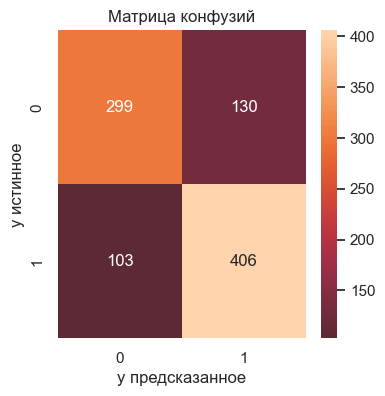

In [ ]:
# Создаем объект класса логистическая регрессия
model = linear_model.LogisticRegression( max_iter = max_iter )

# Обучаем и выводим метрики
_, _ = run_model_fit( model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test )

In [110]:
arr_C_init = [0.01, 0.1, 1, 10] # Пространство поиска гиперпараметра C
param_init = [
    {
        'penalty': ['l2', None], # тип регуляризации
        'solver': ['lbfgs','sag'],
        'C': arr_C_init # Логарифмическая шкала
    }, 
    {
        'penalty': ['l1', 'l2'] ,
        'solver': ['liblinear', 'saga'],
        'C': arr_C_init # Логарифмическая шкала
    }  
]


### <center> **GridSearchCV**, LogisticRegression

Прогон 1 по логарифмической шкале, GridSearchCV
-----------------------------------------------
CPU times: total: 766 ms
Wall time: 2min 53s
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
f1_score на обучающем наборе: 0.85
f1_score на тестовом наборе: 0.78


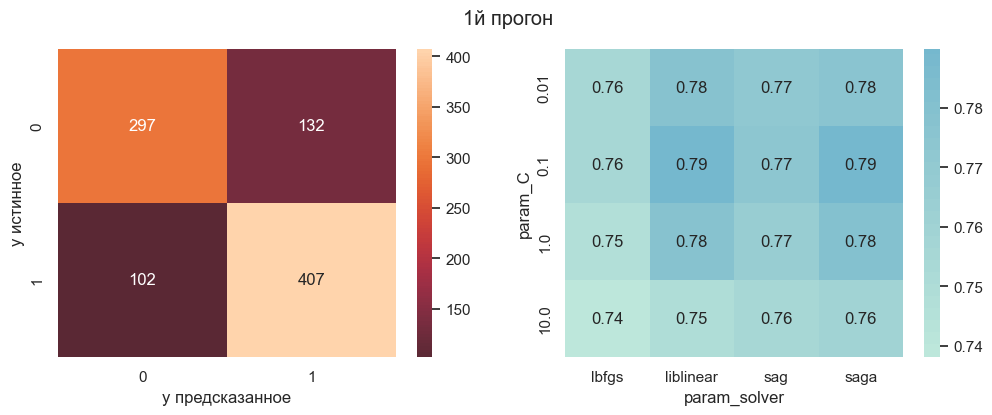



Прогон 2 по линейной шкале, GridSearchCV
--------------------------------------------
Уточняем: C = [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]
CPU times: total: 281 ms
Wall time: 2.83 s
Наилучшие значения гиперпараметров: {'C': 0.13, 'penalty': 'l2', 'solver': 'liblinear'}
f1_score на обучающем наборе: 0.86
f1_score на тестовом наборе: 0.78


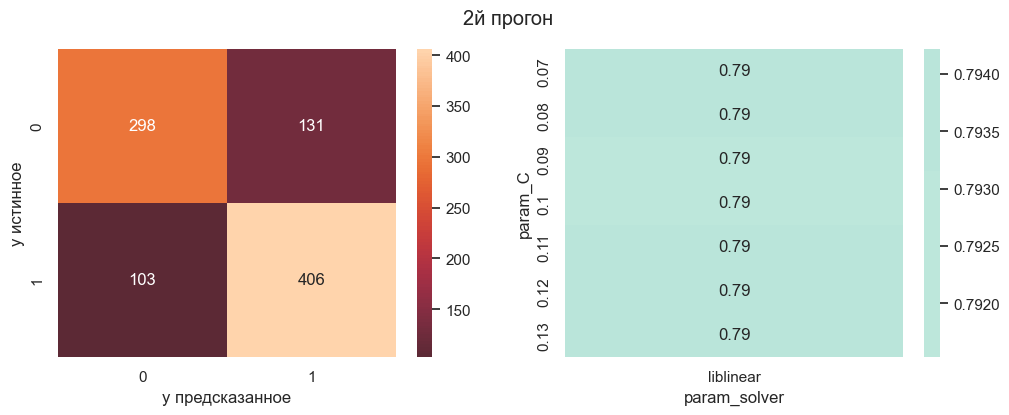

In [111]:
print( "Прогон 1 по логарифмической шкале, GridSearchCV" )
print( "-----------------------------------------------" )
grid_search_init, y_test_pred_init = run_GridSearchCV( 

    params = param_init, # Пространство поиска
    # Создаем объект класса логистическая регрессия
    model = linear_model.LogisticRegression(
        random_state = random_state, # генератор случайных чисел
        max_iter = max_iter # количество итераций на сходимость
    )
)
plot_metrics( grid_search_init.cv_results_, y_test, y_test_pred_init, "1й прогон" )


print( "\n\nПрогон 2 по линейной шкале, GridSearchCV" )
print( "--------------------------------------------" )
arr_c = recalc_param_C( var = grid_search_init.best_params_["C"] ) # Осмотрим окрестность параметра C, [0.7 * C, 1.3 * C]

grid_search_best, y_test_pred_best = run_GridSearchCV( 
    params = {  # Уточненное пространство поиска
        'C': arr_c ,
        'solver': [grid_search_init.best_params_['solver']],
        'penalty': [grid_search_init.best_params_['penalty']],
    },

    # Создаем объект класса логистическая регрессия
    model = linear_model.LogisticRegression(
        random_state = random_state, # генератор случайных чисел
        max_iter = max_iter, # количество итераций на сходимость

        # По науке надо переопределять доп параметры, но ради единообразия печати метрик, добавим в пространство 1 измерения из 1й величины (никак не скажется)
        #solver = grid_search_init.best_params_['solver'],
        #penalty = grid_search_init.best_params_['penalty']
    ),
)
plot_metrics( grid_search_best.cv_results_, y_test, y_test_pred_best, "2й прогон" )


In [112]:
pd.DataFrame(grid_search_best.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.898393,0.070845,0.031694,0.007059,0.07,l2,liblinear,"{'C': 0.07, 'penalty': 'l2', 'solver': 'liblin...",0.798680,0.799368,0.787692,0.801292,0.783570,0.794121,0.007105,2
1,0.924705,0.068047,0.035680,0.002473,0.08,l2,liblinear,"{'C': 0.08, 'penalty': 'l2', 'solver': 'liblin...",0.795380,0.800000,0.787692,0.803226,0.784252,0.794110,0.007180,3
2,1.039322,0.089441,0.035083,0.004104,0.09,l2,liblinear,"{'C': 0.09, 'penalty': 'l2', 'solver': 'liblin...",0.792703,0.797488,0.787037,0.797407,0.783019,0.791531,0.005728,7
3,1.136995,0.043923,0.032093,0.005400,0.10,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.792703,0.800000,0.787037,0.800648,0.783019,0.792681,0.006961,6
4,1.095342,0.069607,0.039063,0.006990,0.11,l2,liblinear,"{'C': 0.11, 'penalty': 'l2', 'solver': 'liblin...",0.794020,0.800000,0.788253,0.800648,0.783019,0.793188,0.006790,5
5,1.182844,0.025382,0.029501,0.012615,0.12,l2,liblinear,"{'C': 0.12, 'penalty': 'l2', 'solver': 'liblin...",0.796020,0.803768,0.788906,0.799353,0.782334,0.794076,0.007618,4
6,0.722186,0.350089,0.010364,0.001352,0.13,l2,liblinear,"{'C': 0.13, 'penalty': 'l2', 'solver': 'liblin...",0.798013,0.803768,0.788906,0.798061,0.782334,0.794217,0.007613,1


Параметры улучшить не удалось. Крайне ресурсоемкий процесс. Даже с логарифмическим подбором параметра. 

Я бы использовал это метод поиска на последней итерации, когда пространство четко определено и вариаций не много, но нужно пройтись по всему пространству или для гчень грубого оценочного посика с малым числов вариантов

### <center> **RandomizedSearchCV**, LogisticRegression

Прогон 1 по логарифмической шкале - RandomizedSearchCV
------------------------------------------------------
CPU times: total: 375 ms
Wall time: 1min 35s
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.76


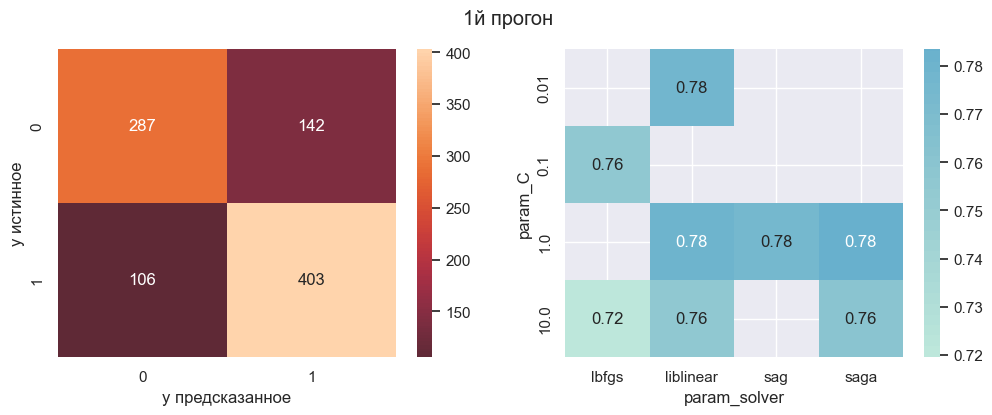



Прогон 2 около точки локального максимума - RandomizedSearchCV
------------------------------------------------------------------
Уточняем: C = [0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013]
CPU times: total: 266 ms
Wall time: 2.09 s
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.013}
f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.77


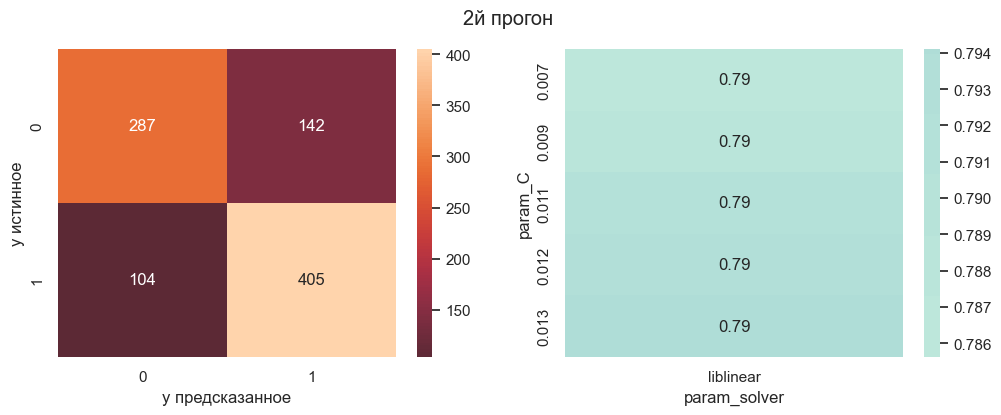

In [113]:
print( "Прогон 1 по логарифмической шкале - RandomizedSearchCV" )
print( "------------------------------------------------------" )
grid_search_init, y_test_pred_init = run_RandomizedSearchCV( 
    params = param_init, # Пространство поиска
    # Создаем объект класса логистическая регрессия
    model = linear_model.LogisticRegression( random_state = random_state, max_iter = max_iter ), 
    cv = cv,     # Количество фолдов
    n_iter = n_iter, # n_iter попыток случайного выбора из пространства гиперпараметров
)
plot_metrics( grid_search_init.cv_results_, y_test, y_test_pred_init, "1й прогон" )

print( "\n\nПрогон 2 около точки локального максимума - RandomizedSearchCV" )
print( "------------------------------------------------------------------" )
arr_c = recalc_param_C( var = grid_search_init.best_params_["C"] ) # Осмотрим окрестность параметра C, [0.7 * C, 1.3 * C]

grid_search_best, y_test_pred_best = run_RandomizedSearchCV( 
    params = { # Уточненное пространство поиска
        'C': arr_c,
        'solver': [grid_search_init.best_params_['solver']],
        'penalty': [grid_search_init.best_params_['penalty']],        
    }, 

    # Создаем объект класса логистическая регрессия
    model = linear_model.LogisticRegression(
        random_state = random_state, # генератор случайных чисел
        max_iter = max_iter, # количество итераций на сходимость

        # По науке надо переопределять доп параметры, но ради единообразия печати метрик, добавим в пространство 1 измерения из 1й величины (никак не скажется)
        #solver = grid_search_init.best_params_['solver'],
        #penalty = grid_search_init.best_params_['penalty']
    ),
    cv = cv, # Количество фолдов
    n_iter = 5, # Пространство сужено до 1 измерения, 5 попыток достаточно
)
plot_metrics( grid_search_best.cv_results_, y_test, y_test_pred_best, "2й прогон" )


In [127]:
pd.DataFrame(grid_search_best.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.386089,0.075258,0.030719,0.010871,liblinear,l1,0.13,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.779772,0.805778,0.795031,0.798722,0.780800,0.792021,0.010190,1
1,0.312340,0.065624,0.029338,0.013295,liblinear,l1,0.10,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.775578,0.798701,0.795031,0.790997,0.772213,0.786504,0.010633,3
2,0.260588,0.051711,0.021892,0.003256,liblinear,l1,0.11,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.778325,0.799353,0.792570,0.795527,0.772947,0.787744,0.010260,2


Результат не улучшился, даже немного хуже, чем при полном переборе GridSearchC, но время вычисления значительно сократилось. В пространстве гиперпараметров большей размерности это ускорение будет существенно. Таким образом, гибко настраивая многомерное пространство поиска, можно достичь хороших значений гиперпараметров, затратив меньше при этом вычислительного ресурса

### <center> Hyperopt, LogisticRegression

Первичный поиск



Прогон 1, hyperopt
----------------------
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [02:12<00:00, 13.23s/trial, best loss: -0.7857071581438055]
Наилучшие значения гиперпараметров: solver = saga, penalty = l1, C = 0.827
f1_score на обучающем наборе: 0.87
f1_score на тестовом наборе: 0.77
CPU times: total: 29.9 s
Wall time: 30.8 s


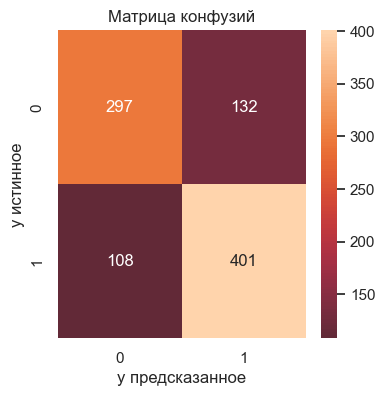

In [119]:
# Настраиваем пространство поиска
solvers1 = ["sag", "lbfgs",'newton-cg']
solvers2 = ['liblinear', 'saga']
penalties1 = ["l2", None]
penalties2 = ["l1", "l2"]

case1 = {
    "penalty1": hp.choice( "penalty1", penalties1 ),
    "solver1": hp.choice( "solver1", solvers1 )
}
case2 = {
    "penalty2": hp.choice( "penalty2", penalties2 ),
    "solver2": hp.choice( "solver2", solvers2 )
}

search_space = {
    "C": hp.uniform( "C", 0.01, 10 ),
    "cases" : hp.choice("cases", [("case1", case1), ("case2", case2)])
}

print( "\n\nПрогон 1, hyperopt" )
print( "----------------------" )
trials = Trials() # используется для логирования результатов

best_params = fmin(
    fn = hyperopt_rf, # функция для оптимизации 
    space = search_space, # пространство гиперпараметров
    algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals = 10, # максимальное количество итераций
    trials = trials, # логирование результатов
    rstate = np.random.default_rng( random_state ), # фиксируем для повторяемости результата
    show_progressbar = True   # progressbar  
)

best_C = best_params["C"]
if best_params["cases"] == 0:
    best_penalty = penalties1[best_params["penalty1"]]
    best_solver = solvers1[best_params["solver1"]]
elif best_params["cases"] == 1:
    best_penalty = penalties2[best_params["penalty2"]]
    best_solver = solvers2[best_params["solver2"]]

best_params = {
    "solver": best_solver,
    "penalty": best_penalty,
    "C": best_C
}

print( f"Наилучшие значения гиперпараметров: solver = {best_solver}, penalty = {best_penalty}, C = {best_C:.3}" )

# Расчитаем модель по этим гиперпараметраам
%time f1_score_train_pred, f1_score_test_pred, y_train_pred, y_test_pred = run_LogisticRegression( X_train, y_train, X_test, y_test, **best_params )


2й прогон - сужаем пространство гиперпараметров



Прогон 2, hyperopt
----------------------
Уточняем: C = [np.float64(0.578656), np.float64(0.661322), np.float64(0.743987), np.float64(0.826652), np.float64(0.909317), np.float64(0.991982), np.float64(1.074648)]
100%|██████████| 5/5 [00:10<00:00,  2.13s/trial, best loss: -0.7790033931759093]
Наилучшие значения гиперпараметров: {'C': np.float64(0.7789264942285796)}
f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78


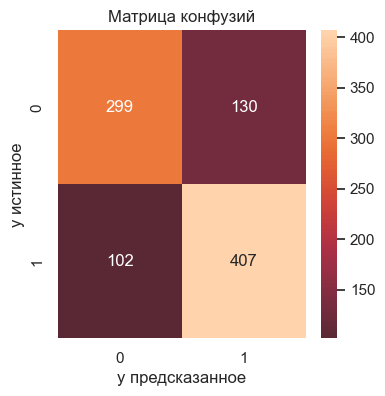

In [121]:
print( "\n\nПрогон 2, hyperopt" )
print( "----------------------" )

arr_c = recalc_param_C( var = best_params["C"] ) # Осмотрим окрестность параметра C, [0.7 * C, 1.3 * C]

search_space = {
    "C": hp.uniform( "C", arr_c[0], arr_c[-1] ),
}

best_params_old = best_params
best_params = {
    "solver": best_params["solver"],
    "penalty": best_params["penalty"],
}

trials = Trials() # используется для логирования результатов

best_params = fmin(
    fn = hyperopt_rf_best, # функция для оптимизации 
    space = search_space, # пространство гиперпараметров
    algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals = 5, # максимальное количество итераций
    trials = trials, # логирование результатов
    rstate = np.random.default_rng( random_state ), # фиксируем для повторяемости результата
    show_progressbar = True   # progressbar  
)

print( f"Наилучшие значения гиперпараметров: {best_params}" )
f1_score_train_pred, f1_score_test_pred, y_train_pred, y_test_pred = run_LogisticRegression( X_train, y_train, X_test, y_test, **best_params )


Результат не улучшился. Но скорость высокая. Гибкая настройка, но несколько сложный этап подготовки

### <center> **Optuna**, LogisticRegression

In [126]:
def optuna_rf( trial, X = X_train, y = y_train, cv = cv ):
    # задаем пространства поиска гиперпараметров
    params = {
        "solver": trial.suggest_categorical('solver', ['saga', 'liblinear', 'lbfgs', 'newton-cg']),
        "penalty": "l2",
        "C": trial.suggest_float('C', 0.01, 10, log = True ),
        "max_iter": max_iter
    }
        
    # создаем модель с предложенным параметром
    model = linear_model.LogisticRegression( **params, verbose = False )
    score = cross_val_score( model, X, y, n_jobs = -1, cv = cv, scoring = "f1").mean()

    return score

[I 2025-11-06 20:50:08,116] A new study created in memory with name: LogisticRegression
[I 2025-11-06 20:50:09,693] Trial 0 finished with value: 0.7849483142539242 and parameters: {'solver': 'liblinear', 'C': 0.2918796919707709}. Best is trial 0 with value: 0.7849483142539242.
[I 2025-11-06 20:50:29,924] Trial 1 finished with value: 0.7631777110486453 and parameters: {'solver': 'saga', 'C': 3.61929715145897}. Best is trial 0 with value: 0.7849483142539242.
[I 2025-11-06 20:50:33,683] Trial 2 finished with value: 0.7573164881972736 and parameters: {'solver': 'newton-cg', 'C': 5.512730069602203}. Best is trial 0 with value: 0.7849483142539242.
[I 2025-11-06 20:50:34,841] Trial 3 finished with value: 0.7954427316040364 and parameters: {'solver': 'lbfgs', 'C': 0.02870401705103704}. Best is trial 3 with value: 0.7954427316040364.
[I 2025-11-06 20:50:56,406] Trial 4 finished with value: 0.7724383398255242 and parameters: {'solver': 'saga', 'C': 1.860854476832733}. Best is trial 3 with value:

Наилучшие значения гиперпараметров {'solver': 'liblinear', 'C': 0.021964707663396234}
f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.77
CPU times: total: 1.11 s
Wall time: 1min 27s


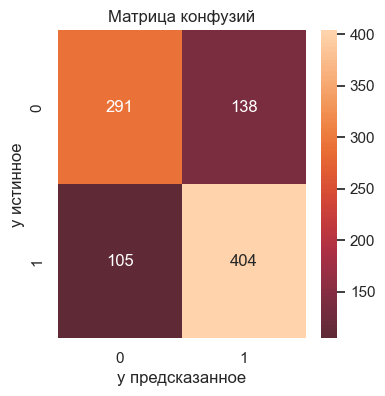

In [127]:
%%time
random_state_tmp = random_state

# cоздаем объект исследования
study = optuna.create_study( study_name = "LogisticRegression", direction = "maximize")

# Запускаем оптимизацию. ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize( optuna_rf, n_trials = 20 )

# Сохраним лучший набор гиперпараметров на 1м шаге
best_params = study.best_params

# выводим результаты на обучающей выборке
print( f"Наилучшие значения гиперпараметров {study.best_params}" )
f1_score_train_pred, f1_score_test_pred, y_train_pred, y_test_pred = run_LogisticRegression( X_train, y_train, X_test, y_test, random_state = random_state, max_iter = max_iter, **study.best_params )

Смотрим завимсимость мкетрики от количество попыток, видим - с 4й попытки взяли максимум.

In [129]:
if optuna.visualization.is_available():
    fig = optuna.visualization.plot_optimization_history( study, target_name = "f1_score" )
    fig.show()

Влияние гиперпараметра на скорость обучения. Видно, что гиперпараметр С сильнее влияет наобучение и его можно оптимизировать в 1ю очередь

In [130]:
if optuna.visualization.is_available():
    fig = optuna.visualization.plot_param_importances( study )
    fig.show()

Посмотрим градиентную картину. Градиент в направоении темных областей  - пусть к оптимизации

In [131]:
if optuna.visualization.is_available():
    fig = optuna.visualization.plot_contour(study, params=["C","solver"])
    fig.show()

Оптимизируем на основе графиков. Сузим пространство приска и запустим линейное распределение в окрестности точки локального максимума

In [133]:
def optuna_rf_best( trial, X = X_train, y = y_train, cv = cv, max_iter = max_iter ):
    # задаем пространства поиска гиперпараметров
    params = {
        "solver": best_params['solver'],
        "penalty": "l2",
        "C": trial.suggest_uniform('C', 0.7 * best_params['C'], 1.3 * best_params['C'] ),
        "max_iter": max_iter
    }
        
    # создаем модель с предложенным параметром
    model = linear_model.LogisticRegression( **params, verbose = False )
    score = cross_val_score( model, X, y, n_jobs = -1, cv = cv, scoring = "f1" ).mean()

    return score

[I 2025-11-06 20:56:15,891] A new study created in memory with name: LogisticRegression
[I 2025-11-06 20:56:16,283] Trial 0 finished with value: 0.7952557128729876 and parameters: {'C': 0.0191582138683195}. Best is trial 0 with value: 0.7952557128729876.
[I 2025-11-06 20:56:16,721] Trial 1 finished with value: 0.7963642236061939 and parameters: {'C': 0.02538562486755608}. Best is trial 1 with value: 0.7963642236061939.
[I 2025-11-06 20:56:17,127] Trial 2 finished with value: 0.7955068444841793 and parameters: {'C': 0.01956234728317688}. Best is trial 1 with value: 0.7963642236061939.
[I 2025-11-06 20:56:17,567] Trial 3 finished with value: 0.7959806669201082 and parameters: {'C': 0.024738700189087498}. Best is trial 1 with value: 0.7963642236061939.
[I 2025-11-06 20:56:17,982] Trial 4 finished with value: 0.7946308377914824 and parameters: {'C': 0.01857032305707591}. Best is trial 1 with value: 0.7963642236061939.
[I 2025-11-06 20:56:18,385] Trial 5 finished with value: 0.7952557128729

Наилучшие значения гиперпараметров {'C': 0.02019729983060724}
f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.77
CPU times: total: 1.81 s
Wall time: 4.4 s


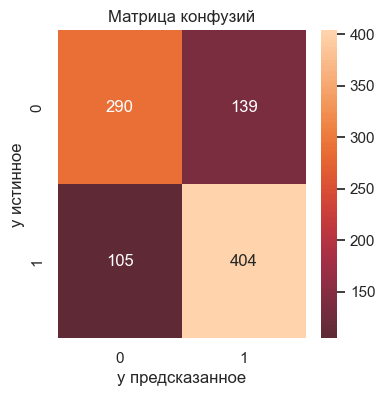

In [134]:
%%time
random_state_tmp = random_state

# cоздаем объект исследования
study = optuna.create_study( study_name = "LogisticRegression", direction = "maximize")

# Запускаем оптимизацию. ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize( optuna_rf_best, n_trials = 10 )

# выводим результаты на обучающей выборке
print( f"Наилучшие значения гиперпараметров {study.best_params}" )
f1_score_train_pred, f1_score_test_pred, y_train_pred, y_test_pred = run_LogisticRegression( X_train, y_train, X_test, y_test, random_state = random_state, max_iter = max_iter, **study.best_params )


Метрики улучшить не удалось, гибкость и высокая скорость. Лучшее соотношение метрика с вычислительным затратам

### <center> **GridSearchCV**, RandomForestClassifier

Смотрим метрики по умолчанию

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.80


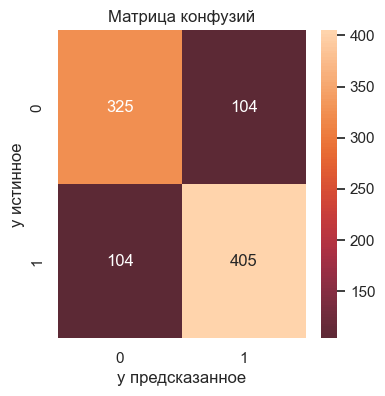

In [169]:
run_RandomForestClassifier( X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, random_state = random_state )

Зададим сетку гиперпараметров

In [145]:
params = {
    'n_estimators': [100, 200], # Количество деревьев решений в лесу
    'max_depth': list( np.linspace( 5, 30, 10, dtype = int ) ), #  глубина каждого дерева 
    'min_samples_leaf': list( np.linspace( 2, 4, 1, dtype = int ) ) #[2, 3, 4, 5], # Минимальное количество листьев
}

CPU times: total: 1.34 s
Wall time: 19.1 s
Наилучшие значения гиперпараметров: {'max_depth': np.int64(21), 'min_samples_leaf': np.int64(2), 'n_estimators': 100}
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.79


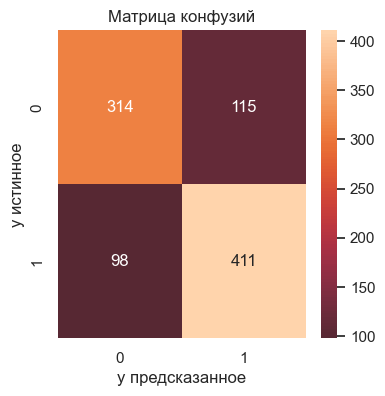

In [146]:
model = ensemble.RandomForestClassifier( random_state = random_state )
grid_search, y_test_pred = run_GridSearchCV( params = params, model = model, cv = cv, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = True )


Снова метрику улучшить не удалось. 

CPU times: total: 1.09 s
Wall time: 5.05 s
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.79


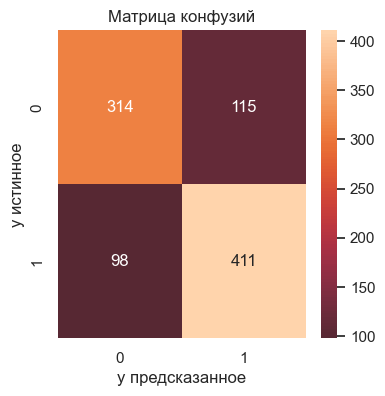

In [148]:
model = ensemble.RandomForestClassifier( random_state = random_state )
params = {
    'n_estimators': [100], # Количество деревьев решений в лесу
    'max_depth': [21], #  глубина каждого дерева 
    'min_samples_leaf': [2], # Минимальное количество листьев
    'min_samples_split': [2, 3, 4],
    #'max_features': [1, 4, None], # 
    'criterion': ['gini', 'entropy'] #
}

grid_search, y_test_pred = run_GridSearchCV( params = params, model = model, cv = cv, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = True )

Снова метрику улучшить не удалось. 

### <center> **RandomizedSearchCV**, RandomForestClassifier

CPU times: total: 1.02 s
Wall time: 9.56 s
Наилучшие значения гиперпараметров: {'n_estimators': np.int64(123), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': np.int64(24), 'criterion': 'entropy'}
f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.79


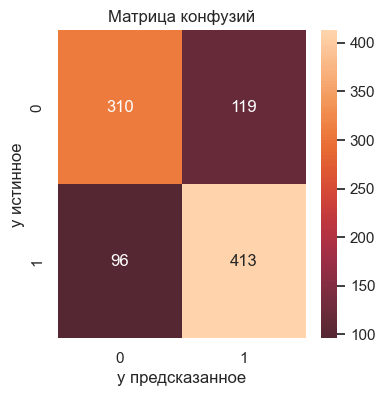

In [152]:
model = ensemble.RandomForestClassifier( random_state = random_state )
params = {
    'n_estimators': list( np.linspace( 50, 250, 50, dtype = int) ), # Количество деревьев решений в лесу
    'max_depth': list( np.linspace( 5, 40, 10, dtype = int ) ), #[2, 10, None], #  глубина каждого дерева 
    'min_samples_leaf': [2, 3, 4, 5], # Минимальное количество листьев
    'min_samples_split': [2, 4],
    'max_features': ["log2"], # 
    'criterion': ['entropy'] #
}

grid_search, y_test_pred = run_RandomizedSearchCV( params = params, model = model, cv = cv, n_iter = 20, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, f_plot = True )


Снова неудача

### <center> **Hyperopt**, RandomForestClassifier

In [153]:
# Зададим пространство поиска гиперпараметров
space_hyperopt = {
    'n_estimators': hp.randint( 'n_estimators', 100, 300 ), # Количество деревьев решений в лесу
    'max_depth' : hp.randint( 'max_depth', 2, 50 ), #  глубина каждого дерева 
    'min_samples_leaf': hp.randint( 'min_samples_leaf', 2, 7 )  # Минимальное количество листьев
    
    #'min_samples_split': [2, 4],
    #'max_features': ["log2"], # 
    #'criterion': ['entropy'] #    
}

In [154]:
############################################################################################
# Функция минимизации, вызывается из интерфейса hyperopt
#
# Минимизации, она должна  и возвращать значение целевой функции.
# Вход: словарь значений гиперпараметров
# Выход: Значение целевой функции.
#
############################################################################################
def hyperopt_rf_RandomForestClassifier( params, cv = cv, X = X_train, y = y_train, random_state = random_state ):
    # функция получает комбинацию гиперпараметров в "params"
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        'min_samples_leaf': int(params['min_samples_leaf'])
    }

    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier( **params, random_state = random_state )

    # обучать модель можно также с помощью кросс-валидации
    score = cross_val_score( model, X, y, cv = cv, scoring = "f1", n_jobs = -1 ).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

############################################################################################
# Функция минимизации, вызывается из интерфейса hyperopt
#
# Минимизации, она должна  и возвращать значение целевой функции.
# Вход: словарь значений гиперпараметров
# Выход: Значение целевой функции.
#
############################################################################################
def run_hyperopt_RandomForestClassifier( X_train, y_train, X_test, y_test ):
    trials = Trials() # используется для логирования результатов

    best_params = fmin(
        fn = hyperopt_rf_RandomForestClassifier, # функция для оптимизации 
        space = space_hyperopt, # пространство гиперпараметров
        algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
        max_evals = 30, # максимальное количество итераций
        trials = trials, # логирование результатов
        rstate = np.random.default_rng( random_state ), # фиксируем для повторяемости результата
        show_progressbar = True   # progressbar  
    )

    print( f"Наилучшие значения гиперпараметров: {best_params}" )

    model = ensemble.RandomForestClassifier( random_state = random_state, **best_params )
    _, _, _, y_test_pred = run_model_fit( model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test )
        
    return (trials, y_test_pred)

100%|██████████| 30/30 [00:51<00:00,  1.73s/trial, best loss: -0.8246620464457735]
Наилучшие значения гиперпараметров: {'max_depth': np.int64(27), 'min_samples_leaf': np.int64(2), 'n_estimators': np.int64(112)}
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.80


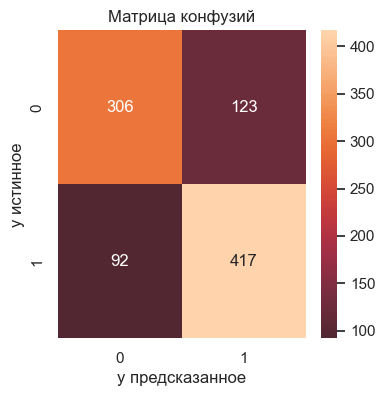

In [155]:
trials, y_test_pred = run_hyperopt_RandomForestClassifier( X_train, y_train, X_test, y_test )

In [161]:
pd.DataFrame( trials.best_trial )

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
loss,2,10,None,-0.824662,NaN,None,None,0,2025-11-06 19:48:59.837,2025-11-06 19:49:01.127
status,2,10,None,ok,NaN,None,None,0,2025-11-06 19:48:59.837,2025-11-06 19:49:01.127
tid,2,10,None,NaN,10,None,None,0,2025-11-06 19:48:59.837,2025-11-06 19:49:01.127
cmd,2,10,None,NaN,"(domain_attachment, FMinIter_Domain)",None,None,0,2025-11-06 19:48:59.837,2025-11-06 19:49:01.127
workdir,2,10,None,NaN,None,None,None,0,2025-11-06 19:48:59.837,2025-11-06 19:49:01.127
idxs,2,10,None,NaN,"{'max_depth': [10], 'min_samples_leaf': [10], ...",None,None,0,2025-11-06 19:48:59.837,2025-11-06 19:49:01.127
vals,2,10,None,NaN,"{'max_depth': [27], 'min_samples_leaf': [2], '...",None,None,0,2025-11-06 19:48:59.837,2025-11-06 19:49:01.127


Видим, что Hyperot не смог улучшить нашу метрику, но нашел точку локального экстремума, причем за меньшее время.

## <center> **Optuna**, RandomForestClassifier

Гиперпараметры по умолчанию

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.80


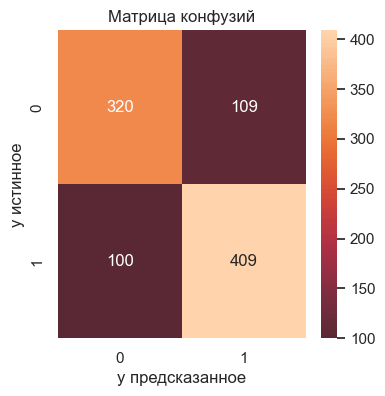

In [157]:
run_RandomForestClassifier( X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, random_state = random_state )

[I 2025-11-06 21:50:25,185] A new study created in memory with name: RandomForestClassifier
[I 2025-11-06 21:50:27,631] Trial 0 finished with value: 0.8207381497647163 and parameters: {'n_estimators': 261, 'max_depth': 22, 'min_samples_leaf': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.8207381497647163.
[I 2025-11-06 21:50:28,947] Trial 1 finished with value: 0.8187527884264728 and parameters: {'n_estimators': 131, 'max_depth': 45, 'min_samples_leaf': 4, 'min_samples_split': 5}. Best is trial 0 with value: 0.8207381497647163.
[I 2025-11-06 21:50:30,264] Trial 2 finished with value: 0.8159872897230909 and parameters: {'n_estimators': 155, 'max_depth': 35, 'min_samples_leaf': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.8207381497647163.
[I 2025-11-06 21:50:32,800] Trial 3 finished with value: 0.8107435757669471 and parameters: {'n_estimators': 359, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}. Best is trial 0 with value: 0.8207381497647163.


Наилучшие значения гиперпараметров: {'n_estimators': 234, 'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4}
f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.80


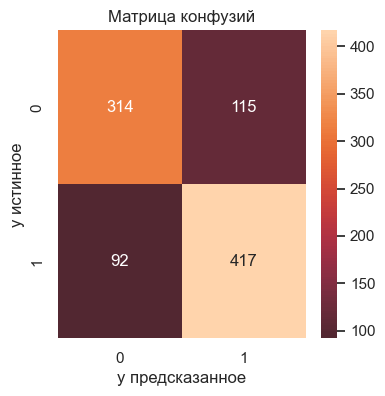

In [158]:
# Определяем функцию с пространством поиска
def get_params_optuna_RandomForestClassifier( trial ):
    optuna_rf_RandomForestClassifier = {
        'n_estimators': trial.suggest_int( 'n_estimators', 100, 400, 1 ), # Количество деревьев решений в лесу
        'max_depth': trial.suggest_int( 'max_depth', 2, 50, 1 ), #  глубина каждого дерева 
        'min_samples_leaf': trial.suggest_int( 'min_samples_leaf', 3, 7, 1 ), # Минимальное количество листьев
        'min_samples_split': trial.suggest_int( 'min_samples_split', 2, 6, 1 )
    }
    return optuna_rf_RandomForestClassifier

# Запускаем поиск
study, y_test_pred = run_optuna_RandomForestClassifier( X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, random_state = random_state, cv = cv, n_trials = 20 )

Улучшить не удалось, но скорость даже при кросс-вадидации впечатляет

Смотрим влияние гиперпараметра на скорость обучения. Видно, что гиперпараметр max_depth сильнее влияет на обучение и его можно оптимизировать в 1ю очередь

In [162]:
if optuna.visualization.is_available():
    fig = optuna.visualization.plot_param_importances( study )
    fig.show()

Посмотрим градиентную картину по 2м приоритетным гиперпараметрам. Градиент в направоении темных областей  - пусть к оптимизации

In [163]:
if optuna.visualization.is_available():
    fig = optuna.visualization.plot_contour(study, params = ["min_samples_leaf","max_depth"])
    fig.show()

Переопределим функцию

[I 2025-11-06 21:54:34,760] A new study created in memory with name: RandomForestClassifier
[I 2025-11-06 21:54:37,003] Trial 0 finished with value: 0.8223418232587406 and parameters: {'max_depth': 40}. Best is trial 0 with value: 0.8223418232587406.
[I 2025-11-06 21:54:39,310] Trial 1 finished with value: 0.8223418232587406 and parameters: {'max_depth': 61}. Best is trial 0 with value: 0.8223418232587406.
[I 2025-11-06 21:54:41,513] Trial 2 finished with value: 0.8223418232587406 and parameters: {'max_depth': 51}. Best is trial 0 with value: 0.8223418232587406.
[I 2025-11-06 21:54:43,739] Trial 3 finished with value: 0.8223418232587406 and parameters: {'max_depth': 38}. Best is trial 0 with value: 0.8223418232587406.
[I 2025-11-06 21:54:45,945] Trial 4 finished with value: 0.8223418232587406 and parameters: {'max_depth': 49}. Best is trial 0 with value: 0.8223418232587406.


Наилучшие значения гиперпараметров: {'max_depth': 40}
f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.80


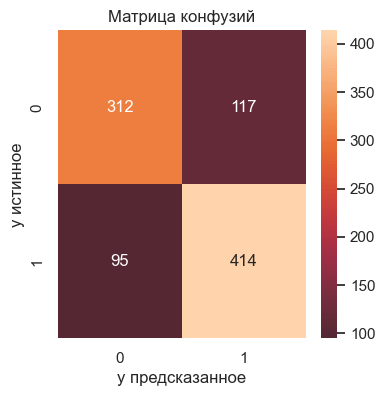

In [165]:
best_params = study.best_params
mult = 0.3 # [0.7, 1.3] * величины

# Зададим новое пространство поиска, для этого пересчитаем параметры из результатов 1го поиска
min_depth_min = int( round( best_params['max_depth'] * (1 - mult), 0) ) # [0.7, 1.3] * max_depth
max_depth_max = int( round( best_params['max_depth'] * (1 + mult), 0) )
min_samples_leaf = best_params['min_samples_leaf'] 
min_samples_split = best_params['min_samples_split']
n_estimators = best_params['n_estimators']

# И зальем их в функцию
def get_params_optuna_RandomForestClassifier( trial ):
    optuna_rf_RandomForestClassifier = {
        'n_estimators': n_estimators, # Количество деревьев решений в лесу
        'max_depth': trial.suggest_int( 'max_depth', min_depth_min, max_depth_max, 1 ), #  глубина каждого дерева 
        'min_samples_leaf': min_samples_leaf, # Минимальное количество листьев
        'min_samples_split': min_samples_split
    }
    return optuna_rf_RandomForestClassifier

# Запускаем повторный поиск
study, y_test_pred = run_optuna_RandomForestClassifier( X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, random_state = random_state, n_trials = 5 )


optuna тоже не смогла улучшить параметры, но весьма гибкая и работает быстрее всех 4х методов поиска

### <center> Вывод

Все 4 метода поиска оптимальных гиперпараметров имеют свои сильные и слабые сторону применения. Для нелинейных моделей нужна продвинутая оптимизация, сетка и случайная сетка тут не поможет. В все-же optuna мне понравился больше других 